In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.dates as mdates
%matplotlib inline
import tensorflow as tf
#from pathlib import Path
import os
from shutil import move, copy
from mpl_finance import candlestick2_ochl, volume_overlay

In [4]:
# Function to create a special symbol data in csv format

def createDataset(path, symbol, en_symbol, head):
    df = pd.read_csv(path)
    df = df[df.Symbol == symbol]
    df.index = pd.to_datetime(df['Date'])
    df = df.drop(columns=['Date']).dropna()
    df = df.head(head)
    
    if not os.path.exists("stock_datasets"):
        os.makedirs("stock_datasets")
    if not os.path.exists("stock_datasets/{}".format(en_symbol)):
        os.makedirs("stock_datasets/{}".format(en_symbol))
        
    path = "stock_datasets/{}/{}.csv".format(en_symbol, en_symbol)

    df.to_csv(path)
    
    print("{} dataset created.".format(en_symbol))
    print("Dataset path is: {}/{}".format(os.getcwd(), path))

In [5]:
# Function for labeling

def createLabel(path, days):
    print("Creating label . . .")
    
    # remove existing label file
    filename = path.split('/')
    label_path = "{}/{}/{}_label_{}days.txt".format(filename[0], filename[1], filename[2][:-4], days)

    df = pd.read_csv(path, parse_dates=True, index_col=0)
    df.fillna(0)

    df.reset_index(inplace=True)
    df['Date'] = df['Date'].map(mdates.date2num)
    for i in range(0, len(df)):
        c = df.loc[i:i + int(days), :]

        starting = 0
        endvalue = 0
        label = ""
        
        if len(c) == int(days)+1:
            starting = c["Last"].iloc[-2] 
            endvalue = c["Last"].iloc[-1]
            if endvalue > starting:
                label = 1
            else:
                label = 0
            with open(label_path, 'a') as the_file:
                the_file.write("{}-{},{}".format(filename[2][:-4], i, label))
                the_file.write("\n")
    print("Create label finished.")
    print("Label path is: {}/{}".format(os.getcwd(), label_path))

In [6]:
# Function for making candlestick chart images

def createCandles(path, days, pic_size, use_volume):
    print("Converting numerical data to candlestick chart...")
    symbol = path.split('/')[-1]
    symbol = symbol.split('.')[0]
    print("Symbol: {}".format(symbol))
    main_path = "{}".format(os.getcwd())
    #print(main_path)
    if use_volume:
        if not os.path.exists("{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume".format(main_path, symbol, days, pic_size, pic_size)):
            os.makedirs("{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume".format(main_path, symbol, days, pic_size, pic_size))
    else:
        if not os.path.exists("{}/stock_datasets/{}/images/{}days_{}x{}pixel".format(main_path, symbol, days, pic_size, pic_size)):
            os.makedirs("{}/stock_datasets/{}/images/{}days_{}x{}pixel".format(main_path, symbol, days, pic_size, pic_size))

    df = pd.read_csv(path, parse_dates=True, index_col=0)
    df.fillna(0)
    plt.style.use('dark_background')
    df.reset_index(inplace=True)
    df['Date'] = df['Date'].map(mdates.date2num)
    for i in range(0, len(df)):
        # Candle Stick Chart
        c = df.loc[i:i + int(days) - 1, :]
        if (len(c) == int(days)) and (i != (len(df) - days)):
        #if len(c) == int(days):
            my_dpi = 96
            fig = plt.figure(figsize=(pic_size/my_dpi, pic_size/my_dpi), dpi=my_dpi)
            ax1 = fig.add_subplot(1, 1, 1)
            candlestick2_ochl(ax1, c['Open'], c['Last'], c['High'], c['Low'], 
                              width=1, colorup='#77d879', colordown='#db3f3f')
            ax1.grid(False)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.axis('off')

            # create the second axis for the volume bar-plot
            # Add a second axis for the volume overlay
            if use_volume:
                ax2 = ax1.twinx()
                # Plot the volume overlay
                bc = volume_overlay(ax2, c['Open'], c['Last'], c['Volume'],
                                    colorup='#77d879', colordown='#db3f3f', alpha=0.5, width=1)
                ax2.add_collection(bc)
                ax2.grid(False)
                ax2.set_xticklabels([])
                ax2.set_yticklabels([])
                ax2.xaxis.set_visible(False)
                ax2.yaxis.set_visible(False)
                ax2.axis('off')
            if use_volume:
                pngfile = 'stock_datasets/{}/images/{}days_{}x{}pixel+volume/{}-{}.png'.format(symbol, days, pic_size, pic_size, symbol, i)
            else:
                pngfile = 'stock_datasets/{}/images/{}days_{}x{}pixel/{}-{}.png'.format(symbol, days, pic_size, pic_size, symbol, i)
            fig.savefig(pngfile, pad_inches=0, transparent=False)
            plt.close(fig)

    print("Converting numerical data to candlestick chart finished.")
    print('Address is:')
    if use_volume:
        print("{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume".format(main_path, symbol, days, pic_size, pic_size))
    else:
        print("{}/stock_datasets/{}/images/{}days_{}x{}pixel".format(main_path, symbol, days, pic_size, pic_size))

In [7]:
# Function for separating images with different labels and separating train and validation data

def image2dataset(image_path, label_path, train_size):
    label_dict = {}
    with open(label_path) as f:
        for line in f:
            (key, val) = line.split(',')
            label_dict[key] = val.rstrip()
    path = "{}/{}".format(os.getcwd(), image_path)

    folders = ['train', 'validation']
    for folder in folders:
        if not os.path.exists("{}/{}".format(path, folder)):
            os.makedirs("{}/{}".format(path, folder))
    
    i = 0
    for filename in os.listdir(path):
        if label_path.split('/')[1] in filename:
            i += 1
            for k, v in label_dict.items():
                splitname = os.path.splitext(filename)[0].split("-")
                f, e = os.path.splitext(filename)
                newname = "{}-{}".format(splitname[0], splitname[1])
                if newname == k:
                    new_name = "{}{}.png".format(v, f)
                    #os.rename("{}/{}".format(path, filename), "{}/{}".format(path, new_name))
                    if i <= train_size:
                        move("{}/{}".format(path, filename),
                             "{}/train/{}".format(path, new_name))
                    else:
                        move("{}/{}".format(path, filename),
                             "{}/validation/{}".format(path, new_name))
                    break

    folders = ['1', '0']
    for folder in folders:
        if not os.path.exists("{}/train/{}".format(path, folder)):
            os.makedirs("{}/train/{}".format(path, folder))
        if not os.path.exists("{}/validation/{}".format(path, folder)):
            os.makedirs("{}/validation/{}".format(path, folder))

    paths = ["{}/train".format(path), "{}/validation".format(path)]
    for path in paths:
        for filename in os.listdir(path):
            if label_path.split('/')[1] in filename:
                # print(filename[:1])
                if filename[:1] == "1":
                    move("{}/{}".format(path, filename),
                         "{}/1/{}".format(path, filename))
                elif filename[:1] == "0":
                    move("{}/{}".format(path, filename),
                         "{}/0/{}".format(path, filename))
    print('Images converted to classified dataset.')

In [8]:
# Function for combining images of all symbols and preparing a large database

def mergeDatasets(days, pic_size, use_volume):
    symbols = []
    path = 'stock_datasets'
    for i in os.listdir(path):
        if i[0] != '.':
            symbols.append(i)
    main_path = "{}".format(os.getcwd())
    if use_volume:
        if not os.path.exists("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume".format(main_path, days, pic_size, pic_size)):
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/train/0".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/train/1".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/validation/0".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/validation/1".format(main_path, days, pic_size, pic_size))
    else:
        if not os.path.exists("{}/stock_datasets/all_symbols/{}days_{}x{}".format(main_path, days, pic_size, pic_size)):
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/train/0".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/train/1".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/validation/0".format(main_path, days, pic_size, pic_size))
            os.makedirs("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/validation/1".format(main_path, days, pic_size, pic_size))
            
    data_type = ['train', 'validation']
    label = ['0', '1']
    for symbol in symbols:
        if not os.path.exists('{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume'.format(main_path, symbol, days, pic_size, pic_size)):
            continue
        for d in data_type:
            for l in label:
                if use_volume:
                    source_dir = '{}/stock_datasets/{}/images/{}days_{}x{}pixel+volume/{}/{}'.format(main_path, symbol, days, pic_size, pic_size, d, l)
                    target_dir = '{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/{}/{}'.format(main_path, days, pic_size, pic_size, d, l)
                else:
                    source_dir = '{}/stock_datasets/{}/images/{}days_{}x{}pixel/{}/{}'.format(main_path, symbol, days, pic_size, pic_size, d, l)
                    target_dir = '{}/stock_datasets/all_symbols/{}days_{}x{}pixel/{}/{}'.format(main_path, days, pic_size, pic_size, d, l)
                
                file_names = os.listdir(source_dir)
                for file_name in file_names:
                    if file_name[0] != '.':
                        copy("{}/{}".format(source_dir, file_name),
                             "{}/{}".format(target_dir, file_name))
    print("New dataset with all of data created.")

In [9]:
# A function to get the number of images obtained from the previous function

def countImages(days, pic_size, use_volume):
    symbols = []
    path = 'stock_datasets'
    main_path = "{}".format(os.getcwd())
    if use_volume:
        train_0 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/train/0".format(main_path, days, pic_size, pic_size)))
        train_1 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/train/1".format(main_path, days, pic_size, pic_size)))
        valid_0 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/validation/0".format(main_path, days, pic_size, pic_size)))
        valid_1 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel+volume/validation/1".format(main_path, days, pic_size, pic_size)))
    else:
        train_0 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/train/0".format(main_path, days, pic_size, pic_size)))
        train_1 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/train/1".format(main_path, days, pic_size, pic_size)))
        valid_0 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/validation/0".format(main_path, days, pic_size, pic_size)))
        valid_1 = len(os.listdir("{}/stock_datasets/all_symbols/{}days_{}x{}pixel/validation/1".format(main_path, days, pic_size, pic_size)))
    all_images = train_0 + train_1 + valid_0 + valid_1
    all_trains = train_0 + train_1
    all_valids = valid_0 + valid_1
    train_percentage = all_trains / all_images
    validation_percentage = all_valids / all_images
    print('All: {} images'.format(all_images))
    print('{} images for training, include {} images belongs to label 0 and {} belongs to 1.'.format(all_trains, train_0, train_1))
    print('{} images for validation, include {} images belongs to label 0 and {} belongs to 1.'.format(all_valids, valid_0, valid_1))
    print('{:2.2%} for training'.format(train_percentage))
    print('{:2.2%} for validation'.format(validation_percentage))

In [10]:
# Show created pictures
def showImages(path):
    train_0_dir = os.path.join(path, 'train', '0')
    train_1_dir = os.path.join(path, 'train', '1')
    validation_0_dir = os.path.join(path, 'validation', '0')
    validation_1_dir = os.path.join(path, 'validation', '1')

    train_0_names = os.listdir(train_0_dir)
    train_1_names = os.listdir(train_1_dir)
    validation_0_names = os.listdir(validation_0_dir)
    validation_1_names = os.listdir(validation_1_dir)

    nrows = 4
    ncols = 4
    pic_index = 0
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    pic_index += 8
    next_0_pix = [os.path.join(train_0_dir, fname)
                     for fname in train_0_names[pic_index-8:pic_index]]
    next_1_pix = [os.path.join(train_1_dir, fname)
                     for fname in train_1_names[pic_index-8:pic_index]]
    for i, img_path in enumerate(next_0_pix + next_1_pix):
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('off')
        img = mpimg.imread(img_path)
        plt.imshow(img)
    plt.show()

In [261]:
createDataset(path="/Users/omid/tmp/stockMarketPrediction_DL/tse_en.csv", symbol="كاما", en_symbol='bama', head=2500)

bama dataset created.
Dataset path is: /Users/omid/Desktop/4. Kusama2019/stock_datasets/bama/bama.csv


In [262]:
createLabel('stock_datasets/bama/bama.csv', 60)

Creating label . . .
Create label finished.
Label path is: /Users/omid/Desktop/4. Kusama2019/stock_datasets/bama/bama_label_60days.txt


In [76]:
createCandles('stock_datasets/bama/bama.csv', 60, 150, True)

Converting numerical data to candlestick chart...
Symbol: bama
Converting numerical data to candlestick chart finished.
/Users/omid/Desktop/4. Kusama2019/stock_datasets/bama/images/60days_150x150pixel+volume


In [77]:
image2dataset('stock_datasets/bama/images/60days_150x150pixel+volume', 'stock_datasets/bama/bama_label_60days.txt', 2300)

Images converted to classified dataset.


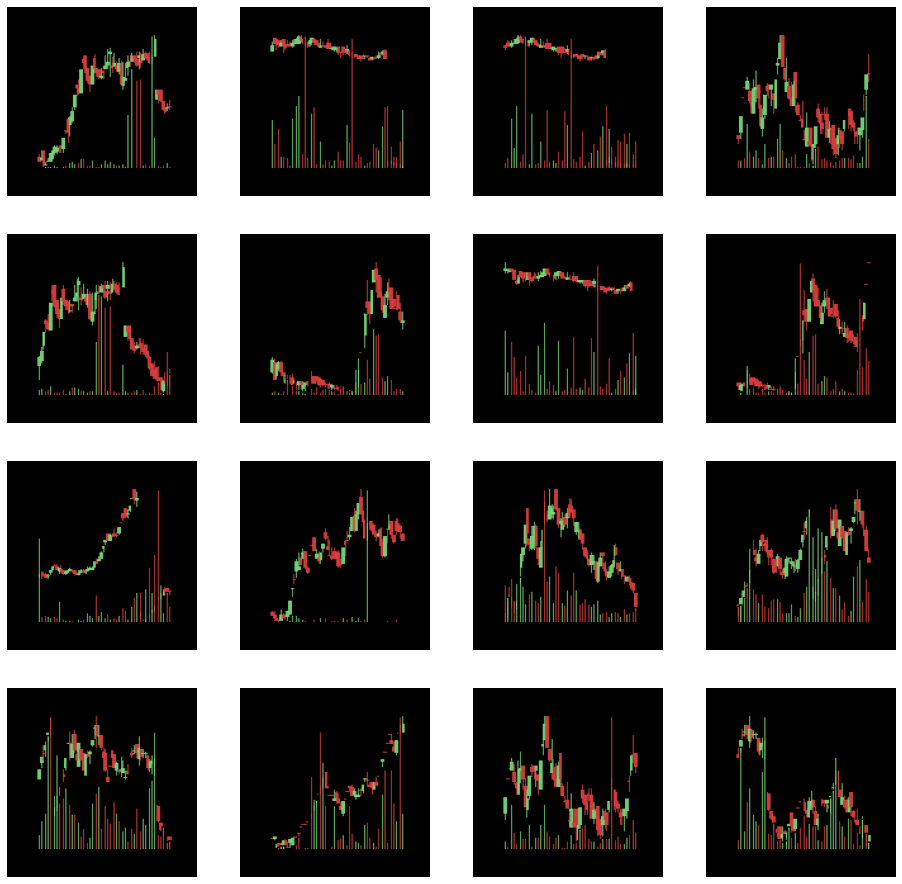

In [11]:
showImages('stock_datasets/وغدير/images/60days_150x150pixel+volume')

In [30]:
path = 'stock_datasets/وغدير/images/60days_150x150pixel+volume'

In [12]:
# Create the model
size = int(path.split('/')[-1].split('_')[-1].split('x')[0])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Show summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [13]:
# Compile the model
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [14]:
# Prepare image to fit the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(os.path.join(path, 'train'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(os.path.join(path, 'validation'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


In [15]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/15
100/100 [==============================] - 23s 223ms/step - loss: 0.7154 - accuracy: 0.5140 - val_loss: 0.7709 - val_accuracy: 0.5341
Epoch 2/15
100/100 [==============================] - 20s 202ms/step - loss: 0.6853 - accuracy: 0.5680 - val_loss: 0.6887 - val_accuracy: 0.5500
Epoch 3/15
100/100 [==============================] - 21s 206ms/step - loss: 0.6421 - accuracy: 0.6300 - val_loss: 0.7093 - val_accuracy: 0.5136
Epoch 4/15
100/100 [==============================] - 21s 208ms/step - loss: 0.5562 - accuracy: 0.7260 - val_loss: 0.7416 - val_accuracy: 0.5295
Epoch 5/15
100/100 [==============================] - 20s 204ms/step - loss: 0.4265 - accuracy: 0.8085 - val_loss: 0.8538 - val_accuracy: 0.5068
Epoch 6/15
100/100 [==============================] - 21s 205ms/step - loss: 0.2902 - accuracy: 0.8840 - val_loss: 1.1051 - val_accuracy: 0.5045
Epoch 7/15
100/100 [==============================] - 23s 230ms/step - loss: 0.1741 - accuracy: 0.9365 - val_loss: 1.3687 - val_ac

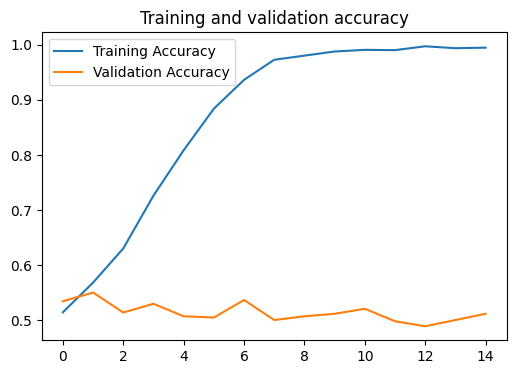

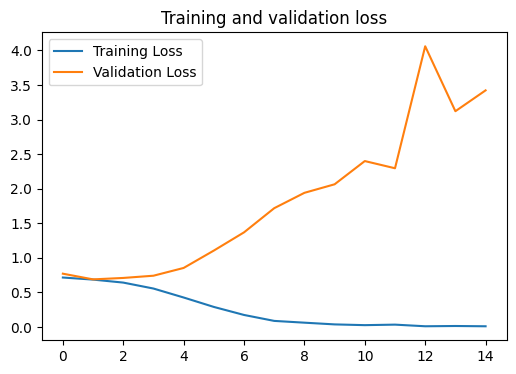

In [16]:
# Show chart of the accuracy and loss for both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.style.use('default')

plt.figure(figsize=(6, 4))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [31]:
# Create the model
size = int(path.split('/')[-1].split('_')[-1].split('x')[0])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(96, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Show summary of the model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 48)        13872     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 48)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 36, 36, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        27712     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 64)       

In [32]:
# Compile the model
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [33]:
# Prepare image to fit the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(os.path.join(path, 'train'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(os.path.join(path, 'validation'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


In [34]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/15
100/100 [==============================] - 26s 255ms/step - loss: 0.7023 - accuracy: 0.5070 - val_loss: 0.6910 - val_accuracy: 0.5341
Epoch 2/15
100/100 [==============================] - 28s 275ms/step - loss: 0.6951 - accuracy: 0.5205 - val_loss: 0.6910 - val_accuracy: 0.5341
Epoch 3/15
100/100 [==============================] - 26s 263ms/step - loss: 0.6940 - accuracy: 0.5130 - val_loss: 0.6918 - val_accuracy: 0.5341
Epoch 4/15
100/100 [==============================] - 25s 250ms/step - loss: 0.6928 - accuracy: 0.5005 - val_loss: 0.7069 - val_accuracy: 0.5341
Epoch 5/15
100/100 [==============================] - 27s 275ms/step - loss: 0.6931 - accuracy: 0.5330 - val_loss: 0.6907 - val_accuracy: 0.5273
Epoch 6/15
100/100 [==============================] - 28s 284ms/step - loss: 0.6902 - accuracy: 0.5385 - val_loss: 0.6904 - val_accuracy: 0.5045
Epoch 7/15
100/100 [==============================] - 28s 277ms/step - loss: 0.6851 - accuracy: 0.5490 - val_loss: 0.6946 - val_ac

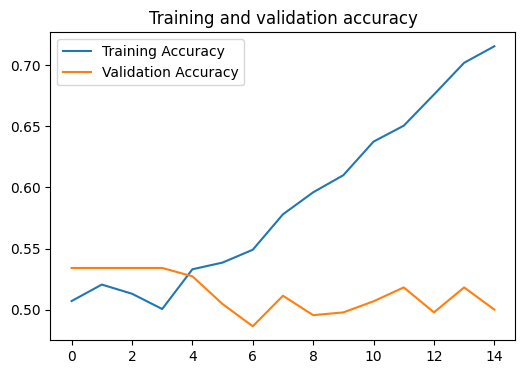

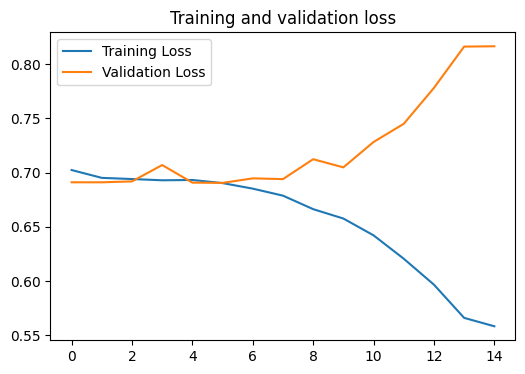

In [35]:
# Show chart of the accuracy and loss for both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.style.use('default')

plt.figure(figsize=(6, 4))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

<ipython-input-36-4cea2263c588>:39: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


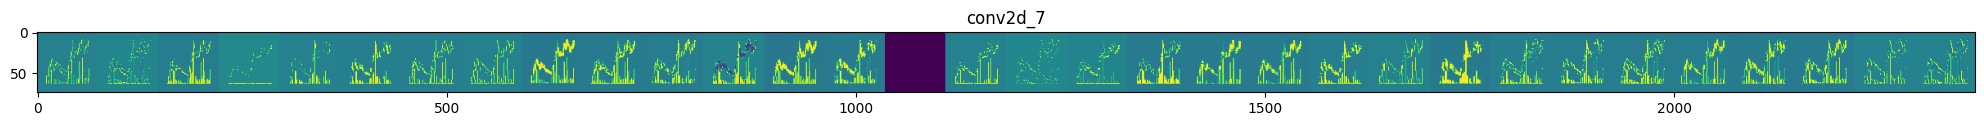

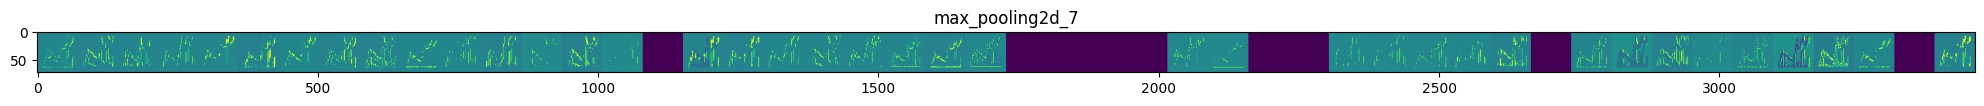

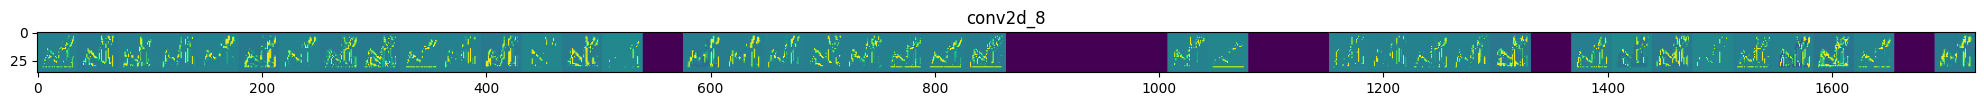

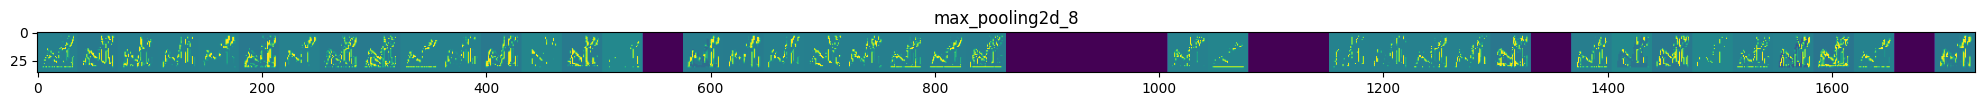

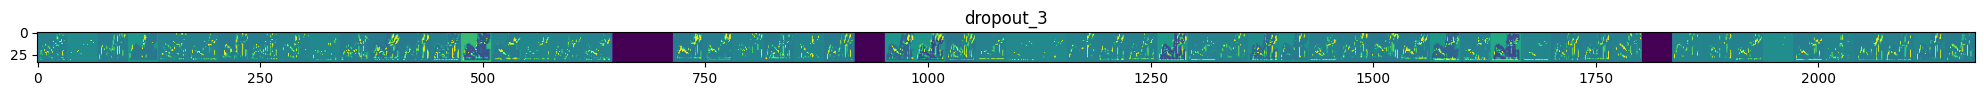

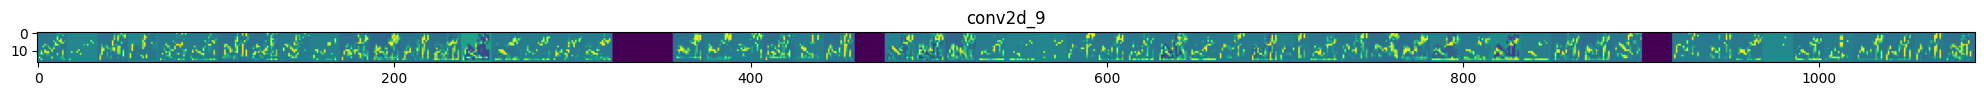

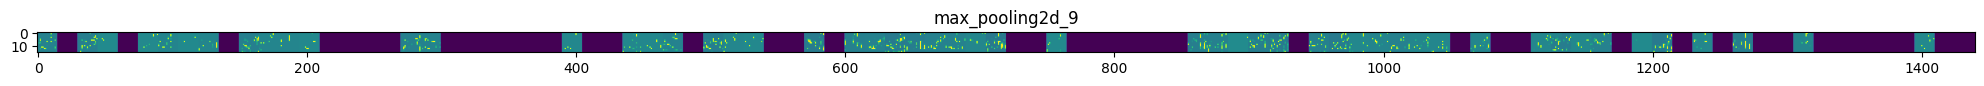

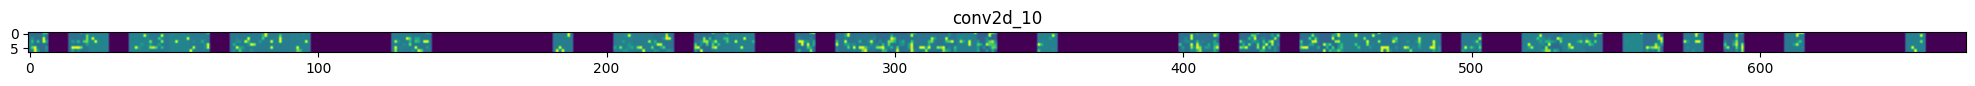

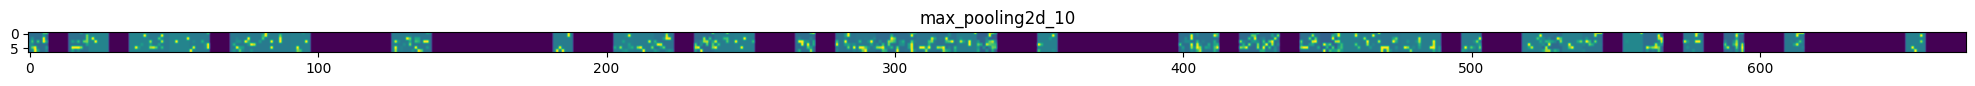

In [36]:
# Visualizing Intermediate Representations
# This is to get a feel for what features our convnet has learned.
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

train_0_dir = os.path.join(path, 'train', '0')
train_1_dir = os.path.join(path, 'train', '1')
validation_0_dir = os.path.join(path, 'validation', '0')
validation_1_dir = os.path.join(path, 'validation', '1')

train_0_names = os.listdir(train_0_dir)
train_1_names = os.listdir(train_1_dir)
validation_0_names = os.listdir(validation_0_dir)
validation_1_names = os.listdir(validation_1_dir)
    
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
img_0_files = [os.path.join(train_0_dir, f) for f in train_0_names]
img_1_files = [os.path.join(train_1_dir, f) for f in train_1_names]
img_path = random.choice(img_0_files + img_1_files)
img = load_img(img_path, target_size=(size, size))

x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

#plt.style.use('dark_background')
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 25. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [38]:
# Test prediction results

from tensorflow.keras.preprocessing import image

test_path = 'stock_datasets/bama/images/60days_150x150pixel+volume/validation/0/0bama-767.png'
img = image.load_img(test_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
    
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
    print("this belong to class 1")
else:
    print("this belong to class 0")

[1.4705183e-14]
this belong to class 0


In [52]:
# Prepare datasets and images for all symbols and assemble a large database

In [54]:
df = pd.read_csv("/Users/omid/tmp/stockMarketPrediction_DL/tse_en.csv")
symbols = df.Symbol.unique()

def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

# Separate sub-symbols and stock rights and symbols that had less than 300 trading days from other symbols
selected_symbols = []

for i in symbols:
    if has_numbers(i) is False and i[-1] != 'ح':
        if len(df[df.Symbol == i]) > 300:
            selected_symbols.append(i)

print(len(selected_symbols))

Done.


In [ ]:
for i in selected_symbols:
    createDataset(path="/Users/omid/tmp/stockMarketPrediction_DL/tse_en.csv", symbol=i, en_symbol=i, head=2500)

In [3]:
for i in selected_symbols:
    path = 'stock_datasets/{}/{}.csv'.format(i, i)
    createLabel(path, 60)

Done.


In [1]:
for i in selected_symbols:
    path = 'stock_datasets/{}/{}.csv'.format(i, i)
    createCandles(path, 60, 150, True)

Done.


In [4]:
for i in selected_symbols:
    image_path = 'stock_datasets/{}/images/60days_150x150pixel+volume'.format(i)
    if os.path.exists(image_path):
        label_path = 'stock_datasets/{}/{}_label_60days.txt'.format(i, i)
        head = round(len(pd.read_csv('stock_datasets/{}/{}.csv'.format(i, i))) * 0.8)
        image2dataset(image_path, label_path, head)

Done.


In [142]:
# This part of the code has been added due to a problem in reading the Persian name of one of the symbols, and it is not necessary.

for i in selected_symbols:
    if os.path.exists('stock_datasets/{}/images'.format(i)):
        if len(os.listdir('stock_datasets/{}/images/60days_150x150pixel+volume'.format(i))) > 3:
            print(i)
            a = i

image_path = 'stock_datasets/{}/images/60days_150x150pixel+volume'.format('asia')
label_path = 'stock_datasets/{}/{}_label_60days.txt'.format('asia', 'asia')
train_size = round(len(pd.read_csv('stock_datasets/{}/{}.csv'.format(a, a))) * 0.8)

image2dataset(image_path, label_path, train_size)

آسيا


In [171]:
mergeDatasets(60, 150, True)

New dataset with all of data created.


In [186]:
countImages(60, 150, True)

All: 593608 images
491291 images for training, include 256851 images belongs to label 0 and 234440 belongs to 1.
102317 images for validation, include 53877 images belongs to label 0 and 48440 belongs to 1.
82.76% for training
17.24% for validation


In [55]:
# Use a pre-trained model

In [56]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_files = '/Users/omid/Downloads/files/Coursera - TensorFlow in Practice Specialization 2020-7/Datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_files)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [57]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [58]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [59]:
from tensorflow.keras.optimizers import RMSprop

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [60]:
base_dir = 'stock_datasets/all_symbols/60days_150x150pixel+volume'

train_dir = 'stock_datasets/all_symbols/60days_150x150pixel+volume/train'
validation_dir = 'stock_datasets/all_symbols/60days_150x150pixel+volume/validation'

train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')
validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')

train_0_fnames = os.listdir(train_0_dir)
train_1_fnames = os.listdir(train_1_dir)

train_datagen = ImageDataGenerator(rescale=1/255)
tst_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = tst_datagen.flow_from_directory(validation_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 491291 images belonging to 2 classes.
Found 102317 images belonging to 2 classes.


In [61]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=20,
    verbose=1)

Epoch 1/100
100/100 [==============================] - 29s 273ms/step - loss: 0.7834 - accuracy: 0.5275 - val_loss: 0.7187 - val_accuracy: 0.5275
Epoch 2/100
100/100 [==============================] - 28s 280ms/step - loss: 0.7130 - accuracy: 0.5070 - val_loss: 0.6894 - val_accuracy: 0.5175
Epoch 3/100
100/100 [==============================] - 27s 269ms/step - loss: 0.6933 - accuracy: 0.5435 - val_loss: 0.6883 - val_accuracy: 0.5425
Epoch 4/100
100/100 [==============================] - 26s 257ms/step - loss: 0.6959 - accuracy: 0.5280 - val_loss: 0.6805 - val_accuracy: 0.5575
Epoch 5/100
100/100 [==============================] - 25s 251ms/step - loss: 0.6935 - accuracy: 0.5470 - val_loss: 0.6988 - val_accuracy: 0.5125
Epoch 6/100
100/100 [==============================] - 26s 257ms/step - loss: 0.6854 - accuracy: 0.5445 - val_loss: 0.6843 - val_accuracy: 0.5325
Epoch 7/100
100/100 [==============================] - 26s 256ms/step - loss: 0.6957 - accuracy: 0.5060 - val_loss: 0.7015 -

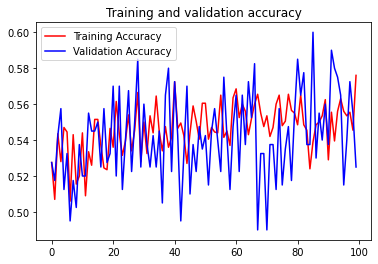

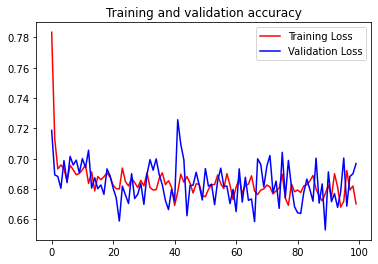

In [62]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6, 4))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

In [63]:
path = 'stock_datasets/all_symbols/60days_150x150pixel+volume'

In [64]:
# Create the model
size = int(path.split('/')[-1].split('_')[-1].split('x')[0])

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(48, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(96, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Show summary of the model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 72, 72, 48)        13872     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 48)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 36, 36, 48)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 34, 34, 64)        27712     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 64)       

In [65]:
# Compile the model
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [66]:
# Prepare image to fit the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(os.path.join(path, 'train'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(os.path.join(path, 'validation'),
                                                    target_size=(size, size),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 491291 images belonging to 2 classes.
Found 102317 images belonging to 2 classes.


In [67]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Epoch 1/100
100/100 [==============================] - 24s 233ms/step - loss: 0.6981 - accuracy: 0.5280 - val_loss: 0.6925 - val_accuracy: 0.5170
Epoch 2/100
100/100 [==============================] - 23s 231ms/step - loss: 0.6941 - accuracy: 0.5245 - val_loss: 0.6917 - val_accuracy: 0.5170
Epoch 3/100
100/100 [==============================] - 23s 231ms/step - loss: 0.6930 - accuracy: 0.5290 - val_loss: 0.6914 - val_accuracy: 0.5240
Epoch 4/100
100/100 [==============================] - 22s 223ms/step - loss: 0.6874 - accuracy: 0.5635 - val_loss: 0.6833 - val_accuracy: 0.5590
Epoch 5/100
100/100 [==============================] - 22s 221ms/step - loss: 0.6855 - accuracy: 0.5470 - val_loss: 0.6833 - val_accuracy: 0.5710
Epoch 6/100
100/100 [==============================] - 22s 220ms/step - loss: 0.6860 - accuracy: 0.5600 - val_loss: 0.6624 - val_accuracy: 0.5980
Epoch 7/100
100/100 [==============================] - 22s 218ms/step - loss: 0.6845 - accuracy: 0.5375 - val_loss: 0.6864 -

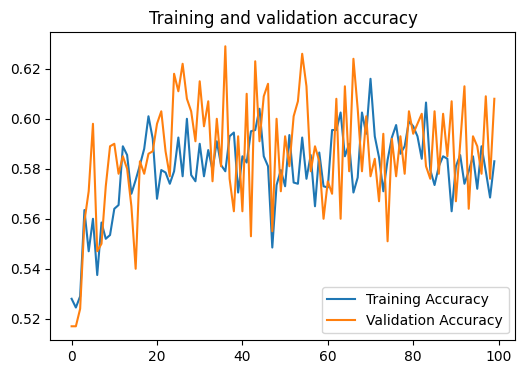

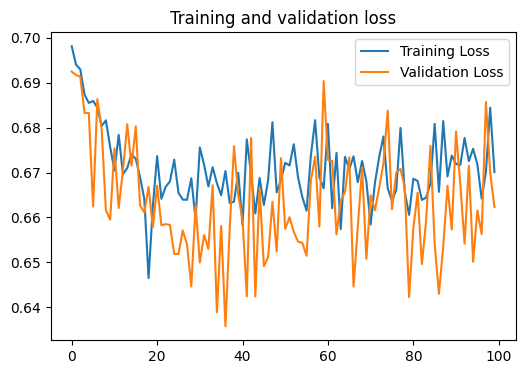

In [68]:
# Show chart of the accuracy and loss for both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.style.use('default')

plt.figure(figsize=(6, 4))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

<ipython-input-47-4cea2263c588>:39: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


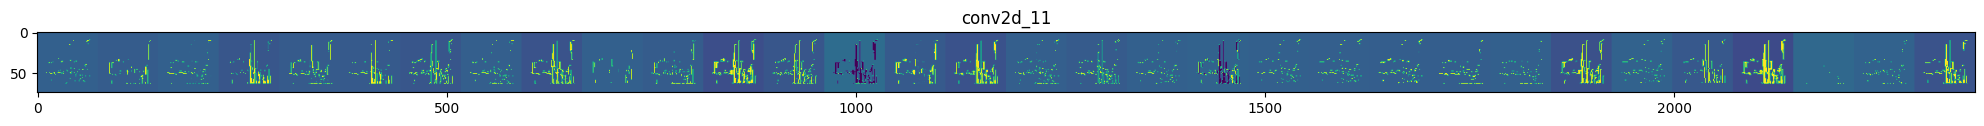

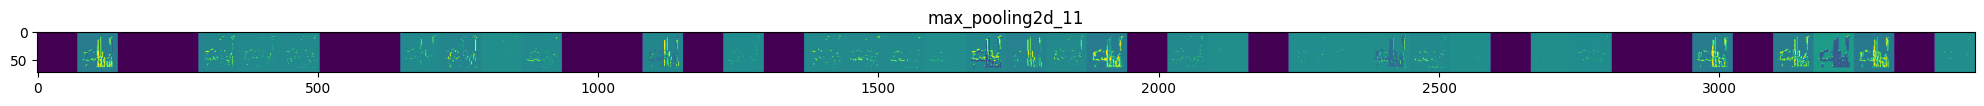

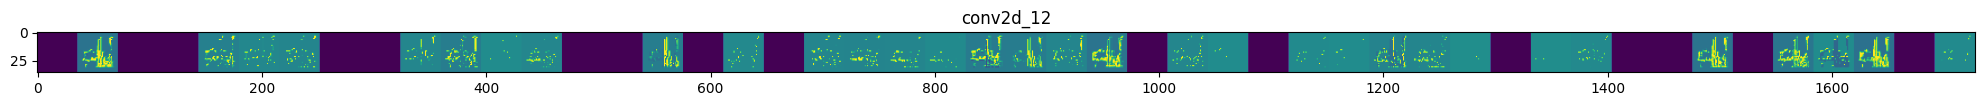

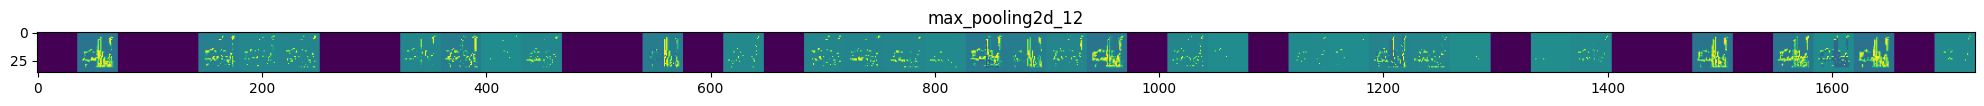

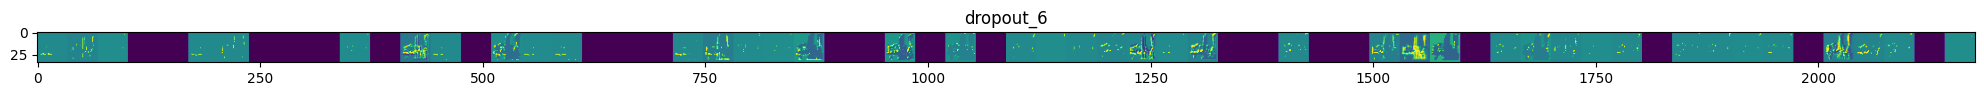

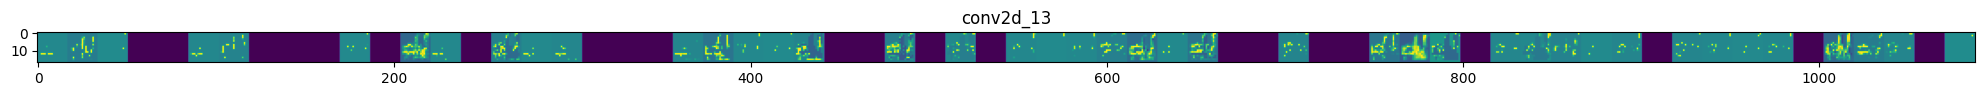

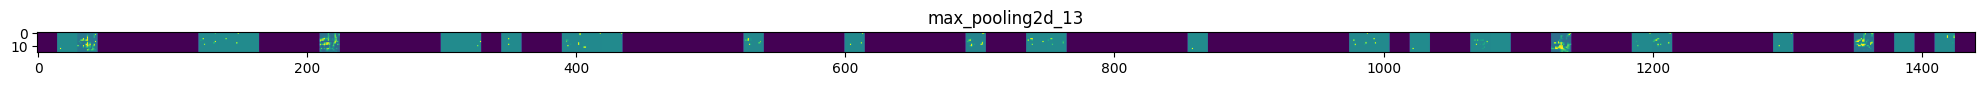

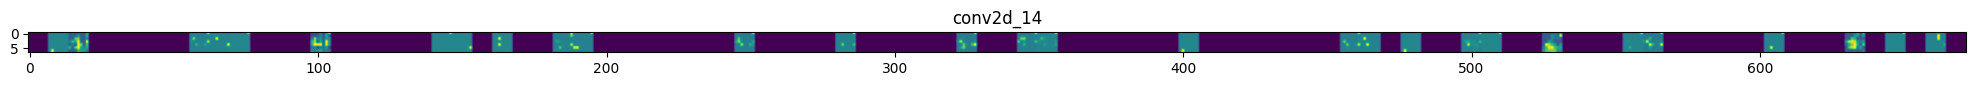

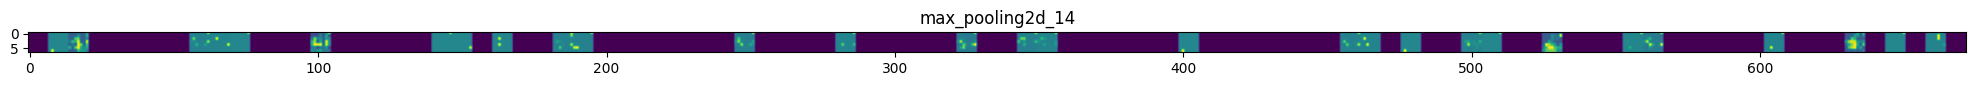

In [47]:
# Visualizing Intermediate Representations
# This is to get a feel for what features our convnet has learned.
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

train_0_dir = os.path.join(path, 'train', '0')
train_1_dir = os.path.join(path, 'train', '1')
validation_0_dir = os.path.join(path, 'validation', '0')
validation_1_dir = os.path.join(path, 'validation', '1')

train_0_names = os.listdir(train_0_dir)
train_1_names = os.listdir(train_1_dir)
validation_0_names = os.listdir(validation_0_dir)
validation_1_names = os.listdir(validation_1_dir)
    
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
img_0_files = [os.path.join(train_0_dir, f) for f in train_0_names]
img_1_files = [os.path.join(train_1_dir, f) for f in train_1_names]
img_path = random.choice(img_0_files + img_1_files)
img = load_img(img_path, target_size=(size, size))

x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

#plt.style.use('dark_background')
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 25. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [48]:
# Test prediction results

from tensorflow.keras.preprocessing import image

test_path = 'stock_datasets/bama/images/60days_150x150pixel+volume/validation/0/0bama-767.png'
img = image.load_img(test_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
    
images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
    print("this belong to class 1")
else:
    print("this belong to class 0")

[1.]
this belong to class 1


In [27]:
path = 'stock_datasets/all_symbols/60days_150x150pixel+volume'

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16

local_weights_files = '/Users/omid/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = VGG16(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_files)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [29]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [30]:
last_layer = pre_trained_model.get_layer('block4_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 9, 9, 512)


In [31]:
from tensorflow.keras.optimizers import RMSprop

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [32]:
base_dir = 'stock_datasets/all_symbols/60days_150x150pixel+volume'

train_dir = 'stock_datasets/all_symbols/60days_150x150pixel+volume/train'
validation_dir = 'stock_datasets/all_symbols/60days_150x150pixel+volume/validation'

train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')
validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')

train_0_fnames = os.listdir(train_0_dir)
train_1_fnames = os.listdir(train_1_dir)

train_datagen = ImageDataGenerator(rescale=1/255)
tst_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = tst_datagen.flow_from_directory(validation_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 491291 images belonging to 2 classes.
Found 102317 images belonging to 2 classes.


In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=20,
    verbose=1)

Epoch 1/20
100/100 [==============================] - 108s 1s/step - loss: 1.2838 - accuracy: 0.5310 - val_loss: 0.7385 - val_accuracy: 0.5075
Epoch 2/20
100/100 [==============================] - 112s 1s/step - loss: 0.7226 - accuracy: 0.5045 - val_loss: 0.7724 - val_accuracy: 0.4900
Epoch 3/20
100/100 [==============================] - 115s 1s/step - loss: 0.7053 - accuracy: 0.5275 - val_loss: 0.6835 - val_accuracy: 0.5250
Epoch 4/20
100/100 [==============================] - 106s 1s/step - loss: 0.6945 - accuracy: 0.5245 - val_loss: 0.6835 - val_accuracy: 0.5325
Epoch 5/20
100/100 [==============================] - 100s 1s/step - loss: 0.6877 - accuracy: 0.5395 - val_loss: 0.6922 - val_accuracy: 0.5250
Epoch 6/20
100/100 [==============================] - 103s 1s/step - loss: 0.6930 - accuracy: 0.5245 - val_loss: 0.6833 - val_accuracy: 0.5700
Epoch 7/20
100/100 [==============================] - 101s 1s/step - loss: 0.6873 - accuracy: 0.5370 - val_loss: 0.7039 - val_accuracy: 0.4825

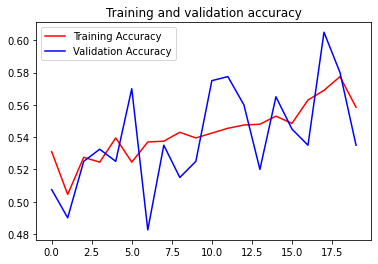

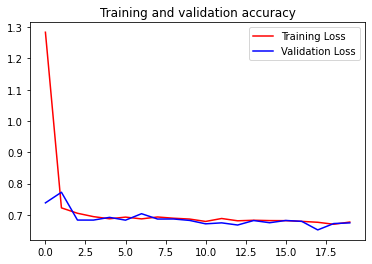

In [34]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6, 4))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

<ipython-input-35-4cea2263c588>:39: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


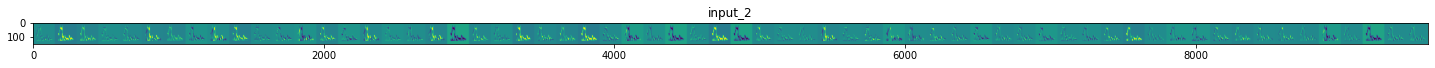

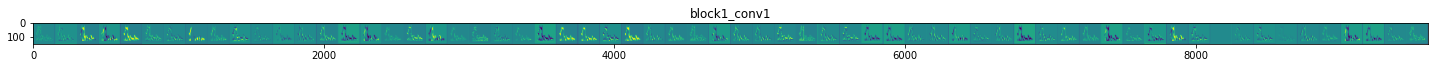

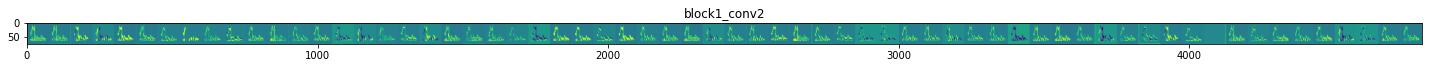

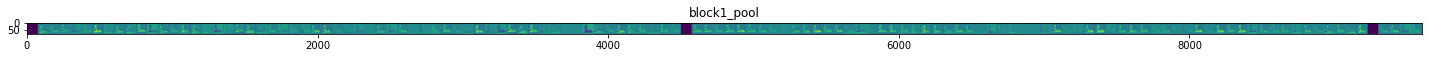

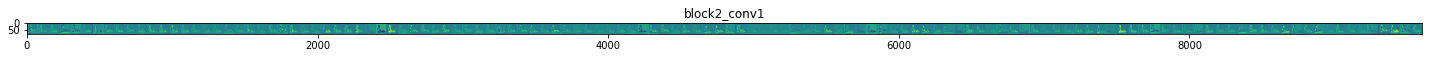

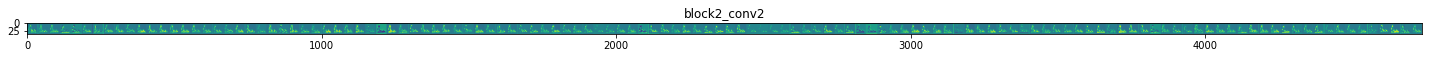

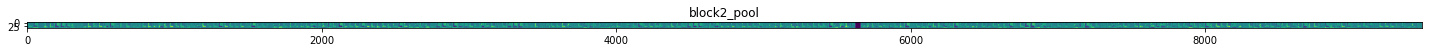

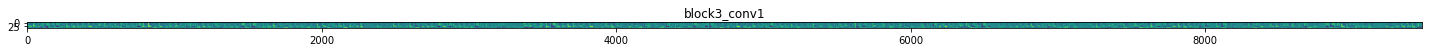

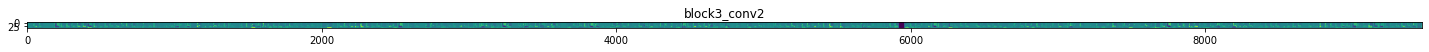

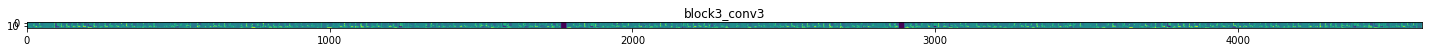

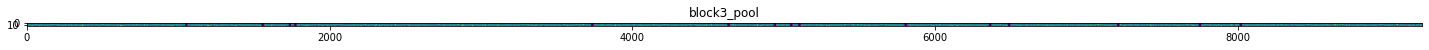

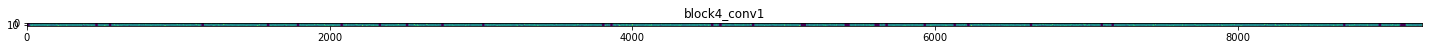

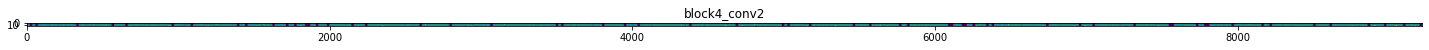

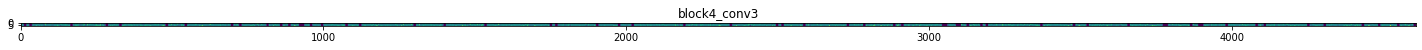

In [35]:
# Visualizing Intermediate Representations
# This is to get a feel for what features our convnet has learned.
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

train_0_dir = os.path.join(path, 'train', '0')
train_1_dir = os.path.join(path, 'train', '1')
validation_0_dir = os.path.join(path, 'validation', '0')
validation_1_dir = os.path.join(path, 'validation', '1')

train_0_names = os.listdir(train_0_dir)
train_1_names = os.listdir(train_1_dir)
validation_0_names = os.listdir(validation_0_dir)
validation_1_names = os.listdir(validation_1_dir)
    
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
img_0_files = [os.path.join(train_0_dir, f) for f in train_0_names]
img_1_files = [os.path.join(train_1_dir, f) for f in train_1_names]
img_path = random.choice(img_0_files + img_1_files)
img = load_img(img_path, target_size=(size, size))

x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

#plt.style.use('dark_background')
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 25. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [36]:
path = 'stock_datasets/all_symbols/60days_150x150pixel+volume'

In [37]:
from tensorflow.keras.applications.resnet50 import ResNet50

local_weights_files = '/Users/omid/Downloads/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = ResNet50(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_files)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [38]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [45]:
last_layer = pre_trained_model.get_layer('conv5_block2_out')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 5, 5, 2048)


In [40]:
from tensorflow.keras.optimizers import RMSprop

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [47]:
base_dir = 'stock_datasets/all_symbols/60days_150x150pixel+volume'

train_dir = 'stock_datasets/all_symbols/60days_150x150pixel+volume/train'
validation_dir = 'stock_datasets/all_symbols/60days_150x150pixel+volume/validation'

train_0_dir = os.path.join(train_dir, '0')
train_1_dir = os.path.join(train_dir, '1')
validation_0_dir = os.path.join(validation_dir, '0')
validation_1_dir = os.path.join(validation_dir, '1')

train_0_fnames = os.listdir(train_0_dir)
train_1_fnames = os.listdir(train_1_dir)

train_datagen = ImageDataGenerator(rescale=1/255)
tst_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = tst_datagen.flow_from_directory(validation_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

Found 491291 images belonging to 2 classes.
Found 102317 images belonging to 2 classes.


In [48]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=20,
    verbose=1)

Epoch 1/20
100/100 [==============================] - 111s 1s/step - loss: 0.6929 - accuracy: 0.5175 - val_loss: 0.6924 - val_accuracy: 0.5375
Epoch 2/20
100/100 [==============================] - 114s 1s/step - loss: 0.6924 - accuracy: 0.5390 - val_loss: 0.6921 - val_accuracy: 0.5475
Epoch 3/20
100/100 [==============================] - 101s 1s/step - loss: 0.6929 - accuracy: 0.5155 - val_loss: 0.6929 - val_accuracy: 0.5150
Epoch 4/20
100/100 [==============================] - 90s 901ms/step - loss: 0.6924 - accuracy: 0.5315 - val_loss: 0.6919 - val_accuracy: 0.5500
Epoch 5/20
100/100 [==============================] - 90s 900ms/step - loss: 0.6925 - accuracy: 0.5290 - val_loss: 0.6915 - val_accuracy: 0.5625
Epoch 6/20
100/100 [==============================] - 89s 891ms/step - loss: 0.6925 - accuracy: 0.5255 - val_loss: 0.6930 - val_accuracy: 0.5075
Epoch 7/20
100/100 [==============================] - 98s 977ms/step - loss: 0.6921 - accuracy: 0.5365 - val_loss: 0.6930 - val_accuracy

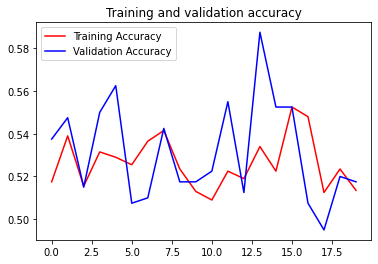

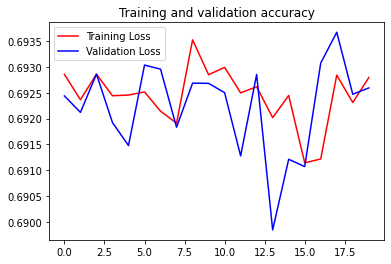

In [49]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6, 4))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()